In [1]:
import sys
from pathlib import Path

# Add project root to path
root = Path.cwd()
while not (root / "src").exists() and root != root.parent:
    root = root.parent
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

# Imports
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from src.pipelines import HotelCancellationClassification
from src.utils import ModelMetadata


In [2]:
RAW_DATA_PATH = root / "data" / "raw" / "hotel_bookings.csv"
DATA_PATH = root / "data" / "processed" / "hotel_bookings_processed.csv"
TARGET_COL = "is_canceled"
RANDOM_STATE = 42

In [3]:
# Data Preprocessing
from src.features.preprocessors import HotelPreprocessor, PreprocessingConfig

# Load raw data
df_raw = pd.read_csv(RAW_DATA_PATH)

# Initialize preprocessor with config
config = PreprocessingConfig()
preprocessor = HotelPreprocessor(config=config)

# Fit and transform the data
df_transformed = preprocessor.fit_transform(df_raw)

# Select only final columns for modeling
df_final = (
    preprocessor
    .select_columns(
        df_transformed,
        include_engineered=True
    )
)

# Save processed data
output_path = preprocessor.save(df_final, "hotel_bookings_processed.csv")

In [4]:
df = pd.read_csv(DATA_PATH)

In [5]:
analysis = HotelCancellationClassification(
    data_path = DATA_PATH,
    target_col = TARGET_COL,
    features = None,  # Use all columns except target
    test_size = 0.2,
    random_state = RANDOM_STATE,
    stratify = True,
    experiment_name = "hotel_cancellation_v1"
)

analysis.prepare_split(val_size = 0.1)

Features: 26 numeric, 12 categorical
Split: train=60580 val=8655 test=17309 | Positive Class proportions: Train=0.276 Val=0.276 Test=0.276


In [ ]:
# Grid Search for Hyperparameter Tuning

# Logistic Regression Grid Search
analysis.grid_search(
    estimator = LogisticRegression(max_iter = 10000, random_state = RANDOM_STATE),
    param_grid  = {
        "C": [0.01, 0.1, 1.0, 10.0, 100.0],
        "penalty": ["l2"],
        "solver": ["lbfgs", "saga"]
    },
    scoring = "f1",
    cv = 5,
    use_validation = True
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


'logisticregression_grid'

In [ ]:
# Decision Tree Grid Search
analysis.grid_search(
    estimator = DecisionTreeClassifier(random_state = RANDOM_STATE),
    param_grid={
        "max_depth": [3, 4, 5, 6, 8, 10, None],
        "min_samples_split": [2, 5, 10, 20],
        "min_samples_leaf": [1, 2, 4]
    },
    scoring = "f1",
    cv = 5,
    use_validation = True
)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


/opt/miniconda3/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


'decisiontreeclassifier_grid'

In [ ]:
# Random Forest Grid Search
from sklearn.ensemble import RandomForestClassifier

analysis.grid_search(
    estimator = RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = -1),
    param_grid = {
        "n_estimators": [100, 200, 300],
        "max_depth": [5, 10, 15, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2"]
    },
    scoring = "f1",
    cv = 3,
    use_validation = True
)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


/opt/miniconda3/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


'randomforestclassifier_grid'

In [9]:

from xgboost import XGBClassifier

y_train = analysis.split.y_train
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

analysis.grid_search(
    estimator = XGBClassifier(
        objective = "binary:logistic",
        eval_metric = "logloss",
        tree_method = "hist",
        random_state = RANDOM_STATE,
        verbosity = 0
    ),
    param_grid = {
        'n_estimators': [250, 350],
        'learning_rate': [0.01, 0.1],
        'max_depth': [7, 8],
        'subsample': [0.7, 0.8],
        'colsample_bytree': [0.8, 0.9],
        'scale_pos_weight': [1, pos_weight]
    },
    scoring = "f1_weighted",
    cv = 5,
    use_validation = True
)



Fitting 5 folds for each of 64 candidates, totalling 320 fits


/opt/miniconda3/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


'xgbclassifier_grid'

In [ ]:
analysis.grid_search(
    estimator=XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        random_state=RANDOM_STATE,
        verbosity=0
    ),
    param_grid={
        # Narrow ranges around best values
        'n_estimators': [330, 350, 370],           # ±20 around 350
        'learning_rate': [0.09, 0.1, 0.11],        # ±0.01 around 0.1
        'max_depth': [7, 8, 9],                    # Keep same
        'subsample': [0.75, 0.8, 0.85],            # ±0.05 around 0.8
        'colsample_bytree': [0.85, 0.9, 0.95],     # ±0.05 around 0.9
        'scale_pos_weight': [1, pos_weight],                   # Keep best
    },
    scoring="f1",
    cv=3,
    use_validation=True
)

Fitting 3 folds for each of 486 candidates, totalling 1458 fits


/opt/miniconda3/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


'xgbclassifier_grid'

In [ ]:
analysis.grid_search(
    estimator=XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        random_state=RANDOM_STATE,
        verbosity=0
    ),
    param_grid={
        'n_estimators': [350],  # Search around 350
        'learning_rate': [0.09],    # Fine-tune around 0.1
        'max_depth': [9],                # Your best was 7
        'subsample': [0.8],        # Fine-tune around 0.7
        'colsample_bytree': [0.85], # Fine-tune around 0.9
        'scale_pos_weight': [1, pos_weight],   # Fine-tune around 2.62
        'min_child_weight': [1, 3, 5],         # NEW: helps with imbalance
        'gamma': [0, 0.1, 0.2],                # NEW: regularization
        'reg_alpha': [0, 0.01, 0.1],           # NEW: L1 regularization
        'reg_lambda': [1, 1.5, 2]              # NEW: L2 regularization
    },
    scoring="f1",
    cv=3,  # Reduce CV folds due to large param space
    use_validation=True
)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


/opt/miniconda3/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


'xgbclassifier_grid'

In [13]:
print("\n" + "=" * 70)
print("EXPERIMENT SUMMARY")
print("=" * 70)

analysis.metadata.summary()

# Find best models by different metrics
print("\n" + "-" * 70)
print("BEST MODELS BY METRIC")
print("-" * 70)

for metric in ["test_f1", "test_roc_auc", "test_accuracy"]:
    best = analysis.metadata.best(metric=metric)
    if best:
        print(f"\nBest by {metric}:")
        print(f"  Algorithm: {best['algorithm']}")
        print(f"  Params: {best['hyperparameters']}")
        print(f"  Score: {best['results'].get(metric, 'N/A')}")


EXPERIMENT SUMMARY

EXPERIMENT LOG SUMMARY: hotel_cancellation_v1
Total experiments: 6

All experiments:
1. LogisticRegression(GridSearch) params={'C': 100.0, 'penalty': 'l2', 'solver': 'saga'} metrics={acc=0.783, f1=0.490}
2. DecisionTreeClassifier(GridSearch) params={'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5} metrics={acc=0.787, f1=0.522}
3. RandomForestClassifier(GridSearch) params={'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300} metrics={acc=0.805, f1=0.579}
4. XGBClassifier(GridSearch) params={'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 350, 'scale_pos_weight': 1, 'subsample': 0.8} metrics={acc=0.802, f1=0.587}
5. XGBClassifier(GridSearch) params={'colsample_bytree': 0.85, 'learning_rate': 0.09, 'max_depth': 9, 'n_estimators': 350, 'scale_pos_weight': 1, 'subsample': 0.8} metrics={acc=0.803, f1=0.589}
6. XGBClassifier(GridSearch) params={'colsample_bytree': 0.85,

In [14]:
# Save metadata to JSON
analysis.metadata.save()  # Saves to models/experiments/hotel_cancellation_v1.json

# Save best model by F1 score
analysis.metadata.save_best_model(metric="test_f1")

print("✓ Metadata saved to: models/experiments/hotel_cancellation_v1.json")
print("✓ Best model saved to: models/best_models/")

Metadata written: /Users/otosamada/Documents/University Assignmnets/Programming/Project/DABN13---Project/models/experiments/hotel_cancellation_v1.json (total 6 experiments)
No model file found in /Users/otosamada/Documents/University Assignmnets/Programming/Project/DABN13---Project/models/trained matching algorithm: xgbclassifier
✓ Metadata saved to: models/experiments/hotel_cancellation_v1.json
✓ Best model saved to: models/best_models/


Evaluating best model: XGBClassifier(GridSearch)
Hyperparameters: {'colsample_bytree': 0.85, 'learning_rate': 0.09, 'max_depth': 9, 'n_estimators': 350, 'scale_pos_weight': 1, 'subsample': 0.8}
Loading model: models/trained/xgbclassifier_grid.joblib
Evaluation report saved: reports/figures/best_model_evaluation.png


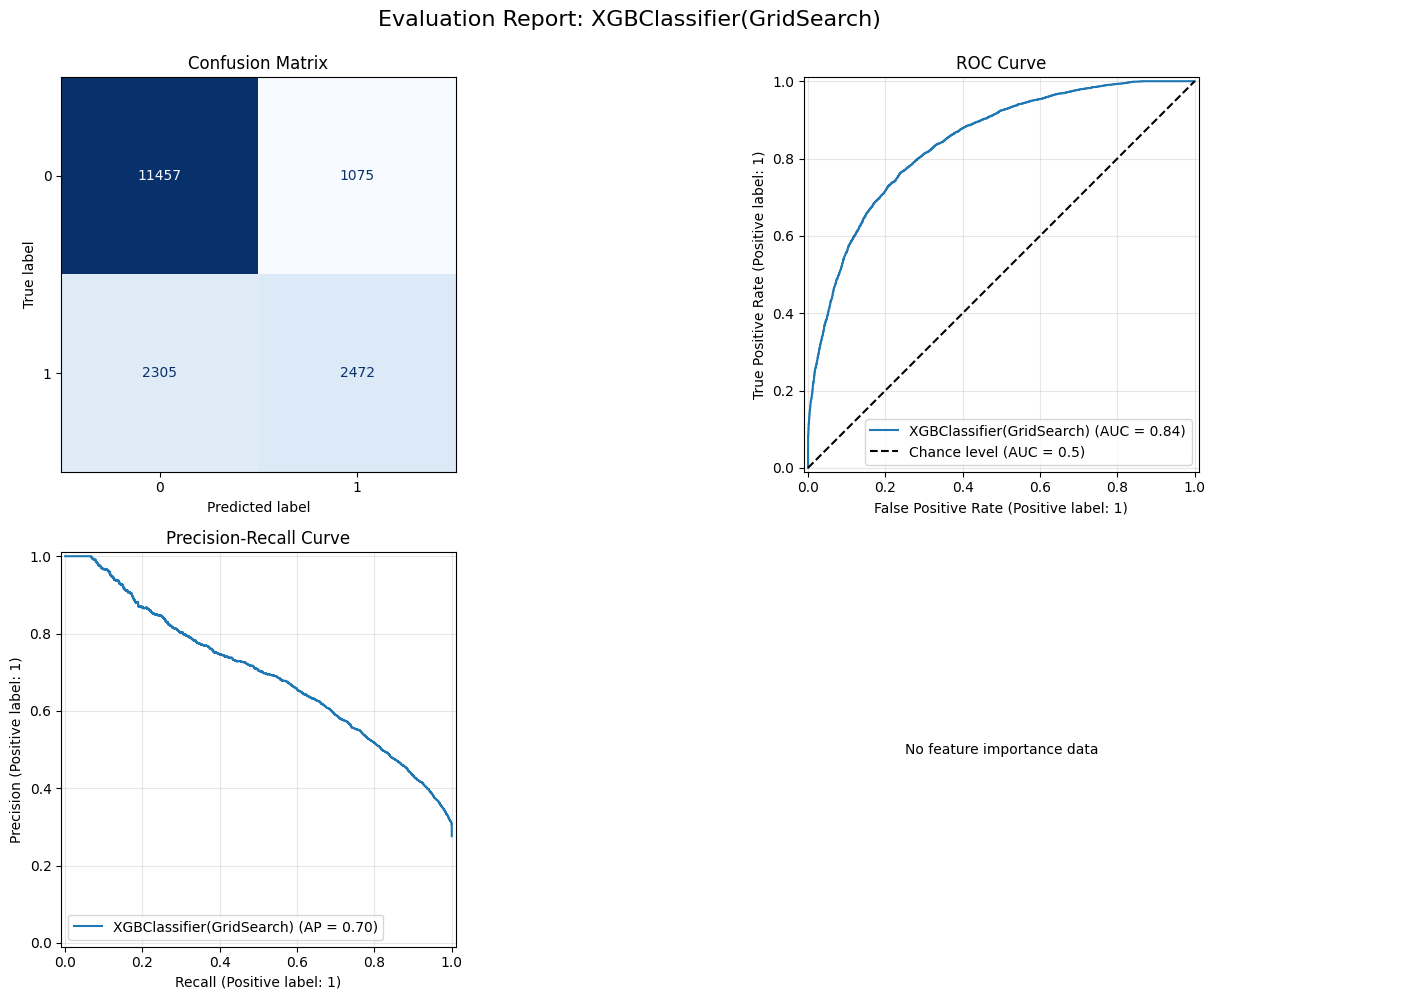

In [15]:
best = analysis.metadata.best(metric="test_f1")

if best:
    print(f"Evaluating best model: {best['algorithm']}")
    print(f"Hyperparameters: {best['hyperparameters']}")
    
    # Comprehensive evaluation report
    analysis.plot_evaluation_report(
        experiment=best,
        figsize=(16, 10),
        save_path="reports/figures/best_model_evaluation.png"
    )
else:
    print("No experiments found.")

XGBoost Feature Importance Analysis


/Users/otosamada/Documents/University Assignmnets/Programming/Project/DABN13---Project/src/pipelines/training_pipeline.py:641: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


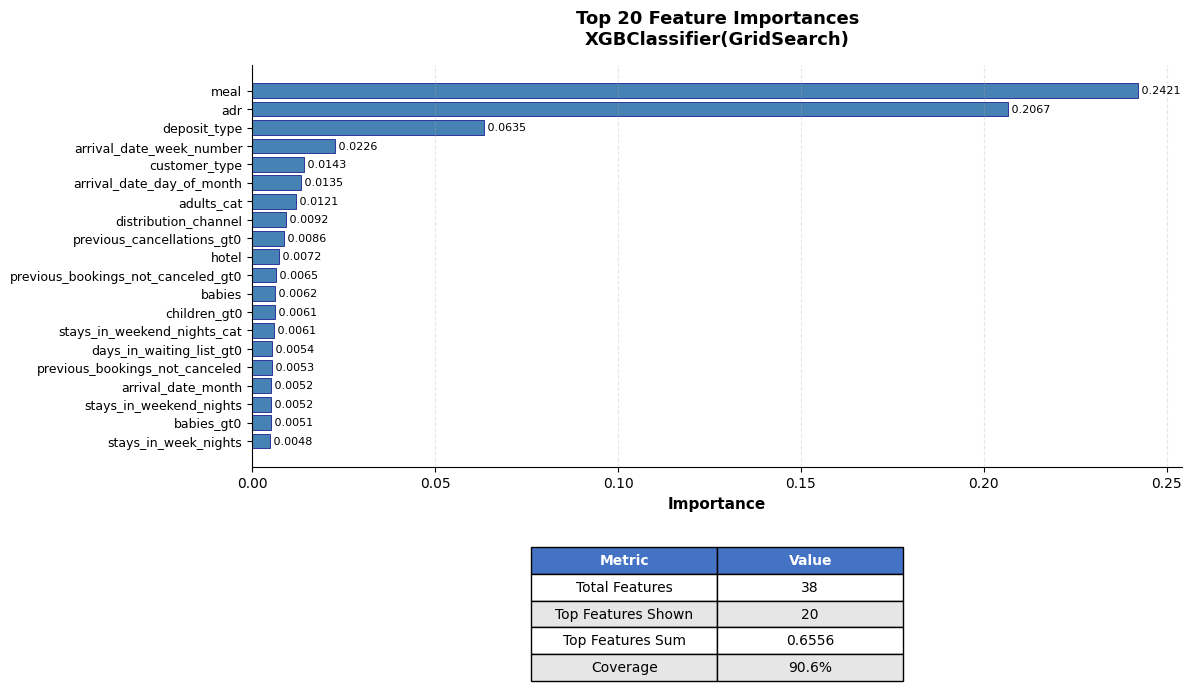

Feature Importance Analysis: XGBClassifier(GridSearch)
1      meal                                     0.2421         33.5%
2      adr                                      0.2067         62.1%
3      deposit_type                             0.0635         70.8%
4      arrival_date_week_number                 0.0226         73.9%
5      customer_type                            0.0143         75.9%
6      arrival_date_day_of_month                0.0135         77.8%
7      adults_cat                               0.0121         79.5%
8      distribution_channel                     0.0092         80.7%
9      previous_cancellations_gt0               0.0086         81.9%
10     hotel                                    0.0072         82.9%
11     previous_bookings_not_canceled_gt0       0.0065         83.8%
12     babies                                   0.0062         84.7%
13     children_gt0                             0.0061         85.5%
14     stays_in_weekend_nights_cat              

In [16]:
best_xgb = analysis.metadata.best(metric="test_f1", algorithm="XGBClassifier(GridSearch)")

if best_xgb:
    print("XGBoost Feature Importance Analysis")
    analysis.display_feature_importance(
        experiment=best_xgb,
        top_n=20,
        figsize=(12, 8)
    )
else:
    print("No XGBoost experiments found.")

In [29]:
analysis.metadata.best()

{'experiment_name': 'hotel_cancellation_v1',
 'timestamp': '2025-10-03T09:27:55.677175',
 'algorithm': 'XGBClassifier(GridSearch)',
 'hyperparameters': {'colsample_bytree': 0.9,
  'learning_rate': 0.1,
  'max_depth': 7,
  'n_estimators': 350,
  'scale_pos_weight': np.float64(2.623615047668127),
  'subsample': 0.7},
 'results': {'val_accuracy': 0.7707595131720845,
  'val_precision': 0.5660788155889397,
  'val_recall': 0.7256488975718671,
  'val_f1': 0.6360078277886497,
  'val_roc_auc': 0.8390561320336897,
  'val_avg_precision': 0.694117497175939,
  'best_cv_score': np.float64(0.6338431069242944),
  'cv_scoring': 'f1',
  'test_accuracy': 0.7707595131720845,
  'test_precision': 0.5660788155889397,
  'test_recall': 0.7256488975718671,
  'test_f1': 0.6360078277886497,
  'test_roc_auc': 0.8390561320336897,
  'test_avg_precision': 0.694117497175939,
  'classification_report': {'0': {'precision': 0.8828227440696149,
    'recall': 0.7879561655495265,
    'f1-score': 0.832696199685181,
    'supp